# Coupled flow/viscous flexure ice shelf model
This notebook couples a slightly modified SSA [(MacAyeal et al., 2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3) with the viscous bending of a thin plate, allowing the approach of a steady-state ice shelf profile under both horizontal viscous flow and vertical viscous deflection. Equations are solved using Firedrake and [icepack](https://github.com/icepack/icepack). Beginning with a shelf in isostatic equilibrium with seawater, the workflow is as follows:

## Workflow

1) **Solve the SSA to obtain a velocity field**
    - this is the modified version from Equation 44 in MacAyeal et al. 
    - see also my [modified SSA notebook](https://github.com/chrismiele/weird_flex/blob/main/flow/modified_SSA.ipynb)<br>
    <br>
2) **Adjust the surface elevation and basal elevation via dynamic thinning only**
    - adjust shelf geometry under *zero surface mass balance* (the ablation rate $\dot{a}$ will be applied in Step 4)
    - dynamically thin the submarine and subaerial parts of the shelf separately
    - this allows us to track the dynamic evolution of surface and basal elevation without assuming equilibrium <br>
    <br>
3) **Solve the viscous Kirchhoff equations to flex the shelf**
    - load relates to surface mass balance and velocity field as outlined in Eq. 57 of MacAyeal et al.
    - see also my [viscous Kirchhoff plate notebook](https://github.com/chrismiele/weird_flex/blob/main/flexure/kirchhoff_plate_viscous.ipynb)
    - in this step, we obtain the vertical deflection rate $\dot{η}$ <br>
    <br>
4) **Adjust geometry over timestep Δt and return to (1)**
    - now use $\dot{a}$ and $\dot{η}$ to modify surface elevation, via ```s = s + aΔt + ηΔt```
    - with no basal mass balance component, ```b = b + ηΔt```
  
After finding the steady-state profile, I provide a description of zero-stress crevasse depths from three sources: surface crevasses from flow, surface crevasses from flexure, and basal crevasses from flexure.

## Imports

In [1]:
path = '/home/sermilik/firedrake_stuff/figures/flow_flexure' #modify to preferred destination for saving figs

from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import numpy as np
from operator import itemgetter
import os
import tqdm #displays progress bars in long-running loops

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```. Deflection will be solved over Argyris elements of order 5, and velocity will be solved over CG elements of order 2. 

In [2]:
nx, ny = 200, 1 #number of elements in x, y
Lx, Ly = 6000, 6000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection rate
w = TestFunction(Q1)
ddη = grad(grad(η)) 
ddw = grad(grad(w))
Δη = div(grad(η)) 
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import year #number of seconds in a year
ρ_i = 917 #ice density value consistent with icepack's, but in kg/m^3
ρ_w = 1024 #water density consistent with icepack, but in kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law
ν_f = 1e17/year #viscosity in the flexure equations need not equal the viscosity from flow

H_gl = 100 #thickness at upstream boundary (m)
thick_grad = 0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

## Modify some icepack modules to solve non-equilibrium SSA

Unlike the classic SSA, this variation does not assume the shelf to be exactly at flotation. We'll tweak icepack's ```gravity``` and ```terminus``` modules to allow the driving stress and terminal cliff boundary condition to reflect this departure from equilibrium. 

In [4]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)

def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min) 
    ν = 1/2*A**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

## Set up the solver

We'll apply the flow-flexure model to the simplest case of a shelf in longitudinal extension. This is achieved by assigning the lateral boundaries in the flow solver to be ```side_wall_ids``` with friction coefficient zero. 

To provide a load for the flexure solver, surface mass balance is chosen to melt out a lake in the shape of a Gaussian curve (see figure below). 

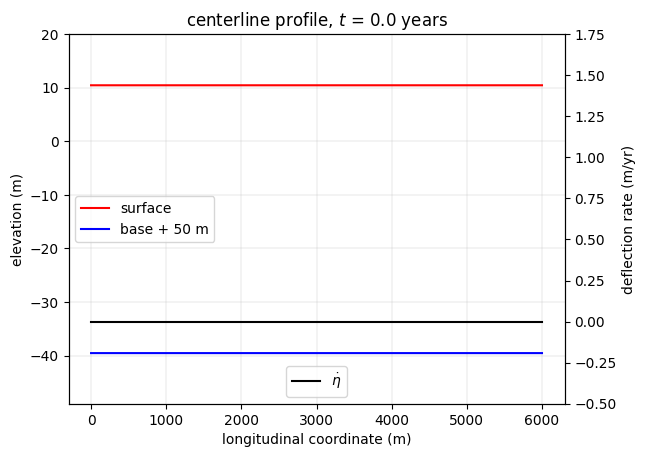

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 1/4 #length of timestep in years
num_timesteps = int(60/Δt) #spin up for 60 years

##################################
##################################
### parameters for flow solver ###
##################################
##################################

ux_gl = 100 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity2, terminus = terminus2, #model is icepack's SSA, but with our own physics
                                 side_friction = icepack.models.friction.side_friction)

flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

#####################################
#####################################
### parameters for flexure solver ###
#####################################
#####################################

α = 1e10 #arbitrary large number for penalty method
a_x = 2*exp(-1/2*((x - Lx/2)/400)**2) #impose an ablation rate (m/yr) as a gaussian curve
a = project(-a_x, Q2) 

#############################
#############################
### plot initial geometry ###
#############################
#############################

os.chdir(path) #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
s0_profile = s0.at(X, tolerance = 1e-10)
b0_profile = np.array(project(b0 + 50, Q2).at(X, tolerance = 1e-10)) #add 25 meters to the basal profile for a better plot window

plt.figure()
plt.title('centerline profile, $t$ = 0.0 years')
plt.plot(s0_profile, color='red', label = 'surface')
plt.plot(b0_profile, color='blue', label = 'base + 50 m')
plt.legend(loc = 'center left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(int(-ϱ*H_gl - H_gl/10) + 50, int((1 - ϱ)*H_gl + H_gl/10))
plt.xticks(np.arange(0, Lx+1, 1000))
plt.grid(linewidth=0.2)
plt.twinx()
plt.ylabel('deflection rate (m/yr)')
plt.ylim(-0.5, 1.75)
plt.plot((0, 6000), (0, 0), color='k', label = '$\dot{η}$')
plt.legend(loc='lower center')
plt.savefig('iteration_0')

## Iteratively solve the flow-flexure problem

We'll also save plots of the surface and basal elevation profiles, along the centerline, at each timestep. The final iteration is shown below. 

100%|█████████████████████████████████████████████████████████████████████████████████| 240/240 [05:36<00:00,  1.40s/it]


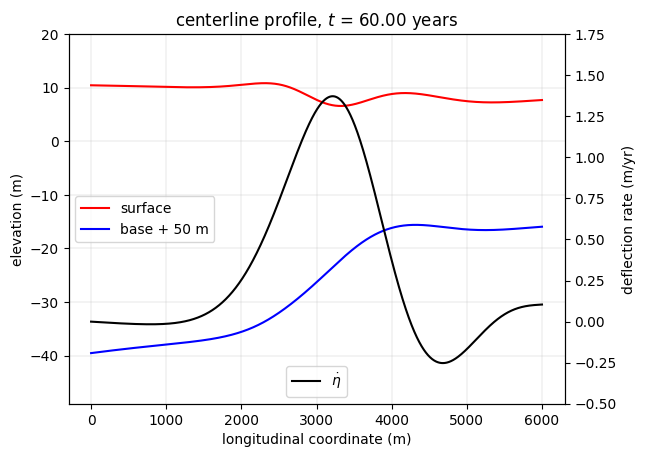

In [6]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), 
                                thickness = H, base = b, fluidity = A)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u, #lower the surface 
                           thickness_inflow = s0, accumulation = Constant(0))
    
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u, #raise the base
                           thickness_inflow = b0, accumulation = Constant(0))

    H = s - b

    ########################################
    ########################################
    ### calculate some useful parameters ###
    ########################################
    ########################################

    ν = effective_viscosity(velocity = u) #in Pa*yrs, for consistency with icepack's velocity units
    ε = sym(grad(u)) #strain rate tensor, /yr
    τ = 2*ν*ε #depth-averaged deviatoric stress tensor in Pascals
    p = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - p*Identity(2) #depth-averaged net stress 

    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################

    h_ab = s + a*Δt + η*Δt - (1 - ϱ)*(H + a*Δt) #this will be the height above buoyancy once η is known

    #force flexure with surface mass balance (see Eq. 57a and 57c of MacAyeal et al. 2021)
    f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                    -ρ_w*g*h_ab, #f acts upward via buoyancy
                    -ρ_i*g*h_ab) #else: f acts downward via gravity
    
    #additionally force flexure with the velocity field, as in Eq. 57e 
    f += H*inner(σ, ddη*Δt) #Eq. 57e

    L = 1/6*ν_f*H**3*inner(ddη, ddw)*dx + 1/6*ν_f*H**3*Δη*Δw*dx - f*w*dx #note the different viscosity value
    L += 0.5*α**2*grad(η)[1]*grad(w)[1]*dx #dη/dy = 0 everywhere, for a proper 1D problem
    L += 0.5*α**2*h_ab*w*ds(1) #constrain h_ab = 0 on the upstream boundary via the penalty method
    L += 0.5*α**2*h_ab*w*ds(2) #and the same at the downstream boundary

    solve(L == 0, η) #η is returned in meters per year

    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    b = project(b + η*Δt, Q2) #b is modified by the deflection
    s = project(s + a*Δt + η*Δt, Q2) #s is modified by deflection and surface mass balance 
    H = project(s - b, Q2) #new thickness

    #################################################
    #################################################
    ### make sure nothing has gone horribly wrong ###
    #################################################
    #################################################
    
    #if we've imposed too much surface melt, the surface may dip below the waterline
    #this breaks the mass conservation equations

    if s.dat.data.min() < 0:
        print('the surface went underwater! that sucks!')
        break
        
    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(project(b + 50, Q2).at(X, tolerance = 1e-10))
    plt.figure()
    plt.title('centerline profile, $t$ = {:.2f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.ylim(int(-ϱ*H_gl) - H_gl/10 + 50, int((1 - ϱ)*H_gl + H_gl/10))
    plt.plot(s_profile, color='red', label = 'surface')
    plt.plot(b_profile, color='blue', label = 'base + 50 m')
    plt.grid(linewidth = 0.2)
    plt.legend(loc = 'center left')
    plt.twinx()
    plt.plot(project(η, Q2).at(X, tolerance = 1e-10), color='k', label = '$\dot{η}$')
    plt.ylabel('deflection rate (m/yr)')
    plt.ylim(-0.5, 1.75)
    plt.legend(loc = 'lower center')
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration

# Incorporating fracture

We'll include a (for now purely descriptive) crevasse depth law using the Nye zero-stress criterion, in which crevasses penetrate to the depth at which the overburden pressure meets the first principal stress (see [this notebook](https://github.com/chrismiele/weird_flex/blob/main/flexure/kirchhoff_plate_viscous.ipynbv) for a flexure application and [this notebook](https://github.com/chrismiele/weird_flex/blob/main/fracture/zero_stress_damage_transport.ipynb) for a flow application). In a coupled flow-flexure problem, the deviatoric stress field is given by 

$$\tau = 2\overline{\nu}\varepsilon - 2\nu_f\nabla^2\dot{\eta}\zeta,$$

where the first term is the flow contribution and the second term is the flexure contribution. For now, we'll consider the two separately. 

## Surface crevasses from flow

With $\tau_1$ the first eigenvalue of $2\overline{\nu}\varepsilon$, crevasse depth is given as $d = \frac{\tau_1}{\rho_ig}$.

In [7]:
from icepack.utilities import eigenvalues
τ_1 = eigenvalues(2*ν*ε)[0]
ds_flow = project(τ_1/(ρ_i*g), Q2)

## Surface crevasses from flexure

Let $\lambda_1$ denote the first eigenvalue of $-2\nu_f\nabla^2\dot{\eta}$. As derived in [this notebook](https://github.com/chrismiele/weird_flex/blob/main/fracture/zero_stress_damage_transport.ipynb), under the Nye criterion, surface crevasses due to flexure will penetrate to a depth of $d = \frac{\lambda_1}{2(\rho_ig + \lambda_1)}H$ wherever this value is positive.

In [8]:
λ_1 = eigenvalues(-2*ν_f*ddη)[0]
ds_flex = λ_1*H/(2*(ρ_i*g + λ_1))
ds_flex = max_value(0, ds_flex) #exclude any extraneous negative depths 
ds_flex = project(ds_flex, Q2)

## Basal crevasses from flexure

Finally, with $\lambda_2$ denoting the second eigenvalue of $-2\nu_f\nabla^2\dot{\eta}$, basal crevasses due to flexure will penetrate to a depth (measured upward from the base) of $d = \frac{\frac{1}{2}\lambda_2 + \rho_ig}{\lambda_2 + \rho_ig}H$ wherever this value falls within the interval $[0, \frac{H}{2}]$. Crevasse depths from all three sources are compared below:

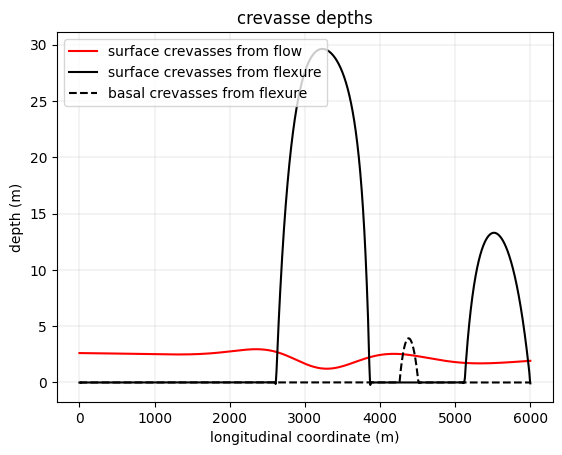

In [9]:
λ_2 = eigenvalues(-2*ν_f*ddη)[1]
db_flex = (1/2*λ_2 + ρ_i*g)/(λ_2 + ρ_i*g)*H
db_flex = max_value(db_flex, 0) #exclude extraneous solutions outside the relevant domain
db_flex = conditional(db_flex >= H/2, 0, db_flex) #relevant solutions are within [0, H/2]
db_flex = project(db_flex, Q2)

ds_flow_profile = np.array(ds_flow.at(X, tolerance = 1e-10))
ds_flex_profile = np.array(ds_flex.at(X, tolerance = 1e-10))
db_flex_profile = np.array(db_flex.at(X, tolerance = 1e-10))
plt.figure()
plt.title('crevasse depths')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('depth (m)')
plt.plot(ds_flow_profile, color='red', label = 'surface crevasses from flow')
plt.plot(ds_flex_profile, color='k', label = 'surface crevasses from flexure')
plt.plot(db_flex_profile, color='k', linestyle = 'dashed', label = 'basal crevasses from flexure')
plt.grid(linewidth = 0.2)
plt.legend(loc = 'upper left')